<a href="https://colab.research.google.com/github/YasinnSoylu/fastai-covid_19-classification/blob/main/fastai_covid_19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"
!pip install fastai==1.0.61


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import torch
from fastai.vision import get_transforms, ImageDataBunch, cnn_learner, ClassificationInterpretation, models 
from fastai.metrics import error_rate, accuracy

In [7]:
image_directory = '/content/drive/MyDrive/covid_dataset/Covid19-dataset'

In [8]:
tfms = get_transforms(do_flip=True, max_rotate=10.0, )

In [9]:
data = ImageDataBunch.from_folder(image_directory, train='train', valid='test', ds_tfms=tfms, size=224, bs=64, num_workers=8)

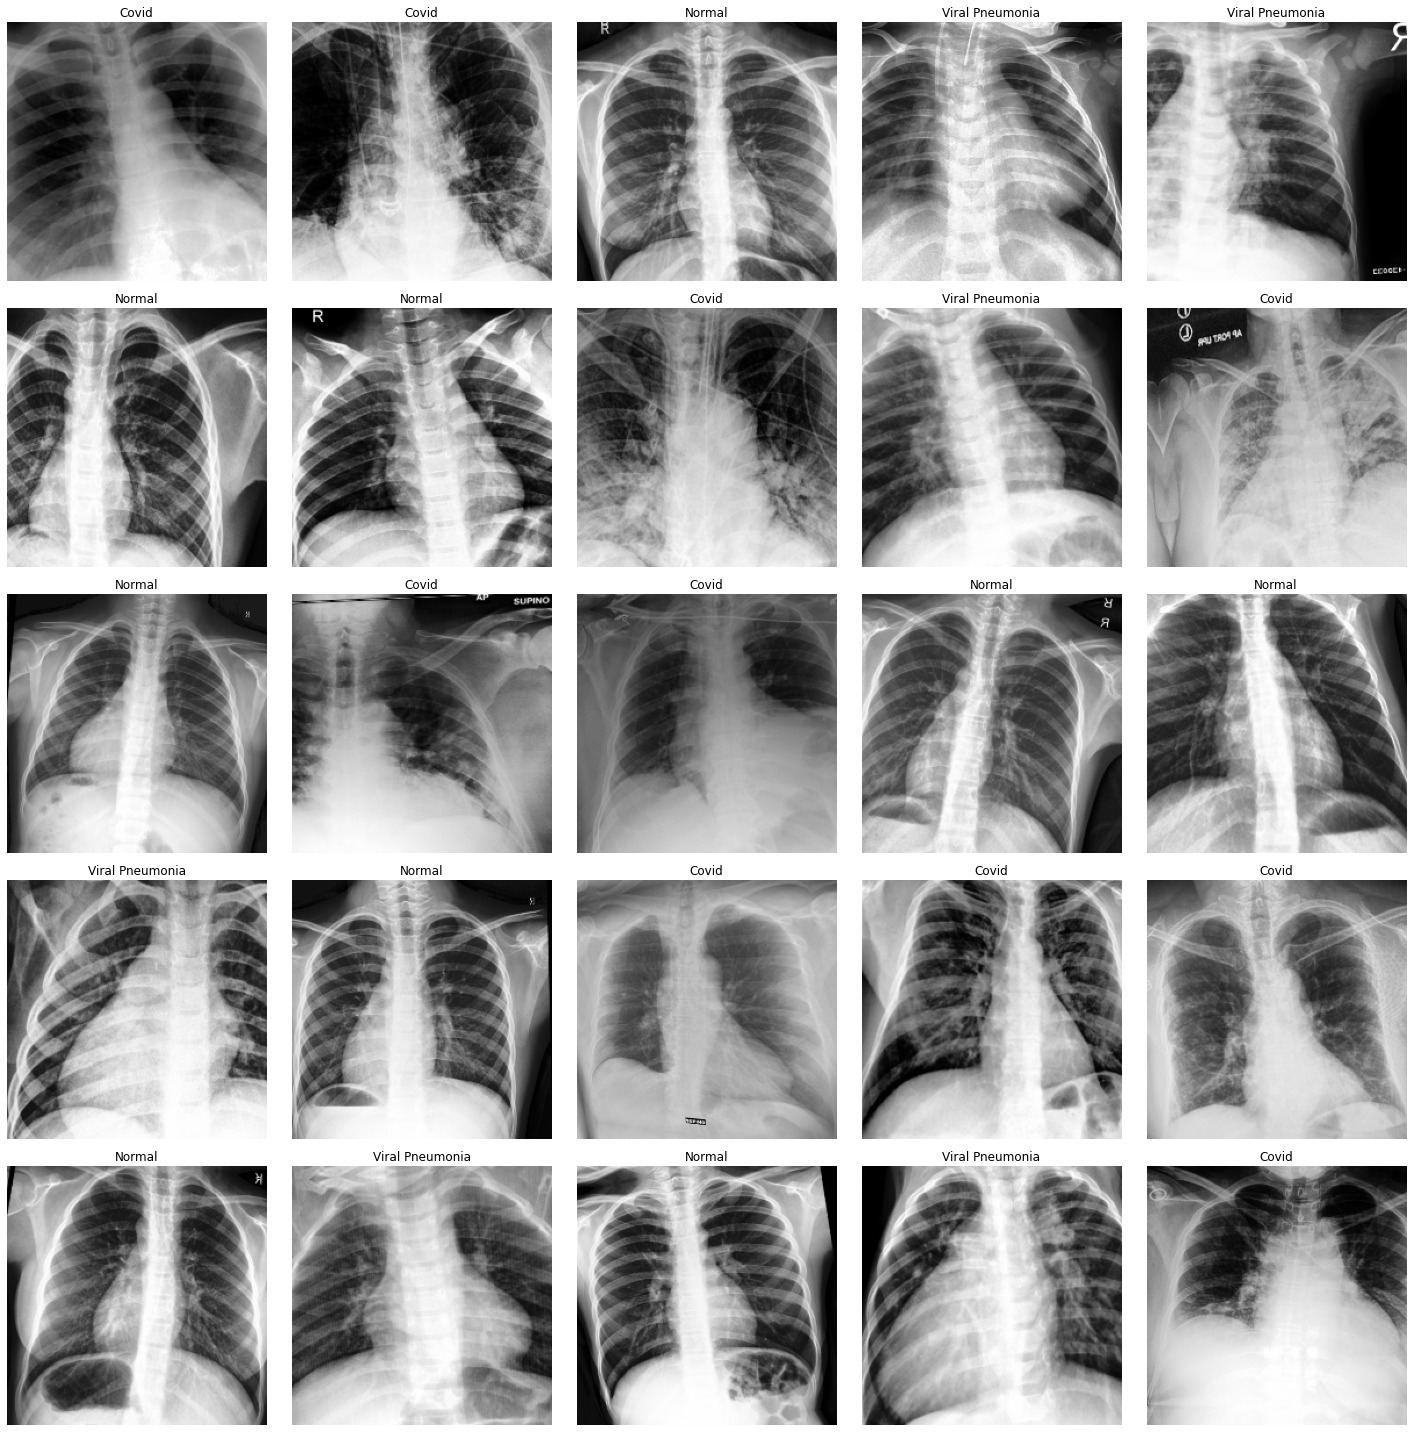

In [10]:
data.show_batch()


In [11]:
print(data.classes,data.c)
print(len(data.train_ds), len(data.valid_ds))

['Covid', 'Normal', 'Viral Pneumonia'] 3
251 66


In [12]:
dir(models)

['BasicBlock',
 'Darknet',
 'DynamicUnet',
 'ResLayer',
 'ResNet',
 'SqueezeNet',
 'UnetBlock',
 'WideResNet',
 'XResNet',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'alexnet',
 'darknet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'mobilenet_v2',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet1_0',
 'squeezenet1_1',
 'unet',
 'vgg11_bn',
 'vgg13_bn',
 'vgg16_bn',
 'vgg19_bn',
 'wrn',
 'wrn_22',
 'xception',
 'xresnet',
 'xresnet101',
 'xresnet152',
 'xresnet18',
 'xresnet18_deep',
 'xresnet34',
 'xresnet34_deep',
 'xresnet50',
 'xresnet50_deep']

In [13]:
learn = cnn_learner(data, models.resnet18, metrics = [accuracy, error_rate])

In [14]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [15]:
learn.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 3.98E-03


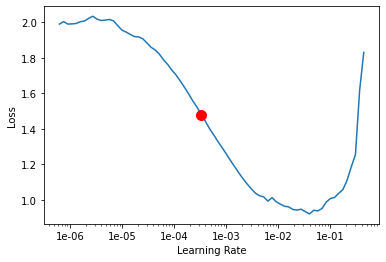

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

 **Fit the model**

In [17]:
# Fit the model over 2 epochs
learn.fit_one_cycle(10, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.107291,2.035441,0.393939,0.606061,00:22
1,1.696711,0.832114,0.666667,0.333333,00:20
2,1.294177,0.703087,0.757576,0.242424,00:22
3,1.044968,0.549520,0.772727,0.227273,00:20
4,0.862582,0.453954,0.818182,0.181818,00:21
5,0.734257,0.320534,0.878788,0.121212,00:20
6,0.638132,0.248855,0.893939,0.106061,00:20
7,0.556477,0.218485,0.909091,0.090909,00:21
8,0.498546,0.206599,0.924242,0.075758,00:19
9,0.459925,0.211185,0.924242,0.075758,00:22


In [19]:
interp = ClassificationInterpretation.from_learner(learn)

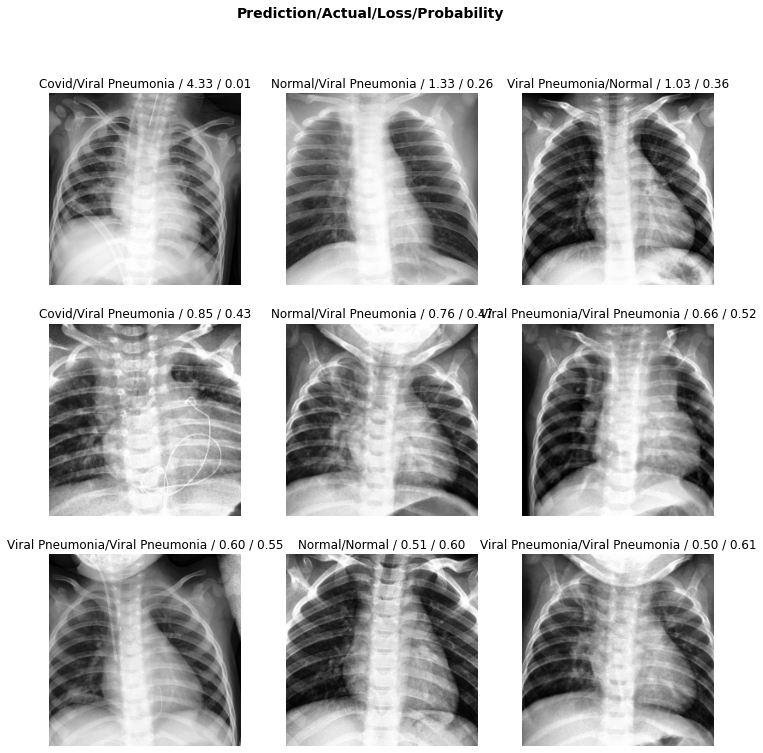

In [20]:
interp.plot_top_losses(9, figsize=(12,12), heatmap=False)

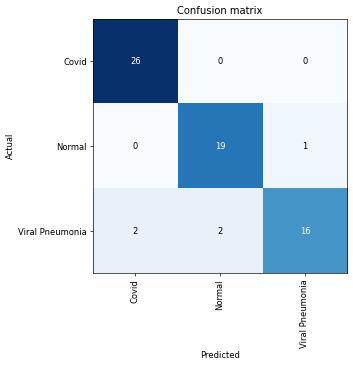

In [21]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [22]:
interp.most_confused(min_val=2) #We are ignoring single image misclassification

[('Viral Pneumonia', 'Covid', 2), ('Viral Pneumonia', 'Normal', 2)]

# strategy2

In [23]:
learner = cnn_learner(data, 
                      models.resnet34, 
                      pretrained=True
                      ,metrics=[error_rate, accuracy]).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.33E-04
Min loss divided by 10: 3.80E-03


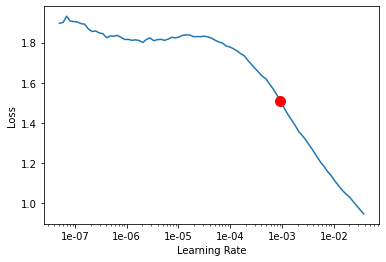

In [24]:
learner.lr_find(start_lr=1e-08,end_lr=0.1, num_it=100) 
learner.recorder.plot(suggestion=True)

In [25]:
mingradlr = learner.recorder.min_grad_lr
print(mingradlr)

0.0009332543007969906


# Training the leraner 


In [26]:
lr = mingradlr
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.026773,3.592415,0.606061,0.393939,00:22
1,1.688340,1.881586,0.484848,0.515152,00:19
2,1.452362,1.156727,0.318182,0.681818,00:20
3,1.234435,0.982107,0.303030,0.696970,00:19
4,1.047412,0.849722,0.287879,0.712121,00:20
5,0.926152,0.773720,0.287879,0.712121,00:20
6,0.829627,0.729089,0.272727,0.727273,00:20
7,0.750547,0.686560,0.257576,0.742424,00:20
8,0.683855,0.668951,0.227273,0.772727,00:20
9,0.628238,0.677415,0.212121,0.787879,00:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.22E-04
Min loss divided by 10: 1.25E-04


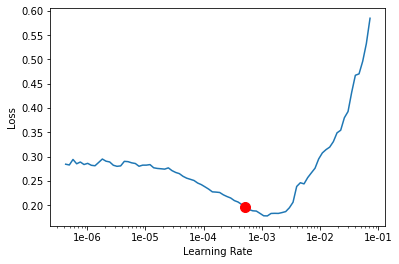

In [27]:
learner.unfreeze()
learner.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [28]:
mingradlr1 = learner.recorder.min_grad_lr
print(mingradlr1)

0.0005219245163512307


# Differential learning

In [29]:
learner.fit_one_cycle(7, slice(mingradlr1, mingradlr1/20))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.256733,0.628342,0.212121,0.787879,00:20
1,0.298728,0.509527,0.196970,0.803030,00:20
2,0.264125,0.586069,0.242424,0.757576,00:20
3,0.234372,0.961035,0.303030,0.696970,00:20
4,0.224255,0.776277,0.257576,0.742424,00:19
5,0.197828,0.587164,0.212121,0.787879,00:19
6,0.184435,0.404574,0.151515,0.848485,00:19


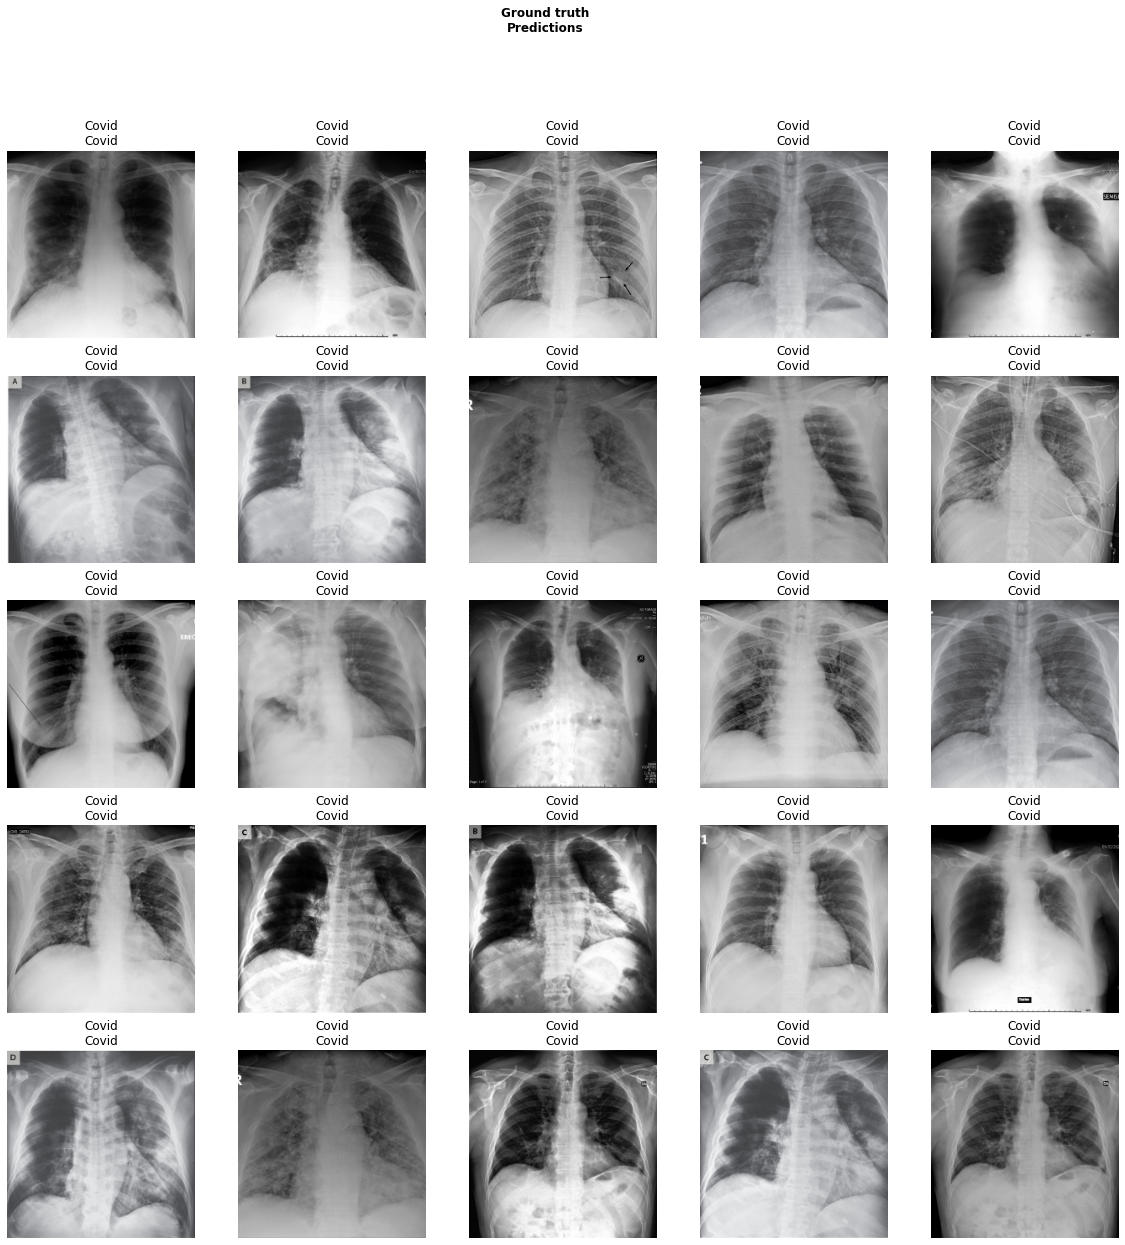

In [30]:
learner.show_results()

In [31]:
interp = ClassificationInterpretation.from_learner(learner)


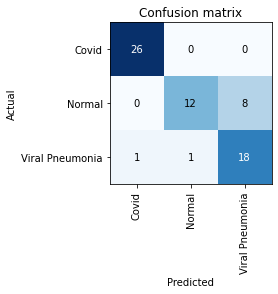

In [32]:
interp.plot_confusion_matrix(title='Confusion matrix')